In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from scipy import optimize
# plt.style.use('unirand')
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
alpha_r=-5.262193843977613e-37
alpha_g=1.0728733273187998e-36


amu=1.6605E-27 # atomic mass unit
mass=6.01512289*amu # mass lithium
h=6.6260715E-34 # planck constant
a_l=6.1E-6
a_s=3.05E-6
E_rl=h**2/8/mass/a_l**2 # in units of 
E_rs=h**2/8/mass/a_s**2
a_xy=2.3E-6
kB=1.380649E-23



In [3]:
def normed(vec):
    return vec/np.linalg.norm(vec)

class field_2D:
    def __init__(self, wavelen,waist_inp,waist_outp,k_vec,pol_vec, src_inp, src_outp, amp ,phase=0):
        self.wavelen=wavelen
        self.waist_outp=waist_outp
        self.waist_inp=waist_inp
        self.k_vec=np.array([k_vec[0],k_vec[1],0])
        self.src_inp=src_inp
        self.src_outp=src_outp
        self.pol_vec=pol_vec
        self.amp=amp
        self.phase=phase

        
        self.k_0 = 2 * np.pi / self.wavelen
        self.inpdir=np.cross(self.k_vec, [0,0,1])
        
        self.zR_inp = np.pi * self.waist_inp ** 2 / self.wavelen
        self.zR_outp = np.pi * self.waist_outp ** 2 / self.wavelen
        
        
    def field(self, x, y, z):
        pos= np.array([x, y, z])
        ax= np.dot(pos,self.k_vec)  # distance along propagation-axis
        ax_inp=ax+self.src_inp
        ax_outp=ax+self.src_outp
        rad = pos - ax * self.k_vec  # orthogonal distance vector
        rad_outp = np.dot(rad, [0,0,1])
        rad_inp = np.dot(rad, self.inpdir)

        w_zinp = self.waist_inp * np.sqrt(1 + (ax_inp / self.zR_inp) ** 2)  # beam waist at axial position
        w_zoutp = self.waist_outp * np.sqrt(1 + (ax_outp / self.zR_outp) ** 2)  # beam waist at axial position
        inv_R_z_inp = ax_inp / (ax_inp ** 2 + self.zR_inp ** 2)  # wavefront curvature
        inv_R_z_outp = ax_outp / (ax_outp ** 2 + self.zR_outp ** 2)  # wavefront curvature
        phi_inp = np.arctan(ax_inp / self.zR_inp)
        phi_outp = np.arctan(ax_outp / self.zR_outp)

        ux = np.sqrt(self.waist_outp / w_zoutp) * np.exp(-rad_outp ** 2 / w_zoutp ** 2) * np.exp(
            -1j * (self.k_0 * ax_outp / 2 + self.k_0 * rad_outp ** 2 * inv_R_z_outp / 4 - phi_outp / 2 ))
        uy = np.sqrt(self.waist_inp / w_zinp) * np.exp(-rad_inp ** 2 / w_zinp ** 2) * np.exp(
            -1j * (self.k_0 * ax_inp / 2 + self.k_0 * rad_inp ** 2 * inv_R_z_inp / 4 - phi_inp / 2 ))
        return self.amp*self.pol_vec * ux * uy *np.exp(-1j*self.phase)
    
    
def intensity(fields, x,y,z):
    allfield=np.zeros(3)
    for field in fields:
        allfield=allfield+field.field(x,y,z)
    return np.linalg.norm(allfield)**2/2/377

In [4]:
# Helper functions:
def group2(lis): # return grouped. reverse direction if reversed array
    length=int(np.floor(len(lis)/2))
    groups=[]
    for i in range(length):
        dwell=[lis[2*i],lis[2*i+1]]
        dwell.sort()
        groups.append(dwell)
    if len(lis)!=0 and lis[0]>=lis[-1]:
        groups=groups[::-1]
        
    return groups

def kvecgen(alpha):
    return np.array([np.cos(alpha),np.sin(alpha)])

def E0_gen(P,wx,wy):
    return np.sqrt(4*377*P/np.pi/wx/wy)

def get_evenly_spaced(array,num): # get evenly spaced array
    idx = np.round(np.linspace(0, len(array) - 1, num)).astype(int)
    return array[idx]

In [5]:
dr_coeff=2*np.pi/360
alpha=10*dr_coeff # interferance angle

k_l=kvecgen(alpha/2)
k_r=kvecgen(-alpha/2)
wavelen_g=532E-9
wavelen_r=1064E-9


# waist_inp=200E-6
# waist_outp=100E-6
polvec=np.array([0,0,1])
# here: left short, right long
w_rl_inpl, w_rl_outpl= 107E-6, 214E-6
w_rs_inpl, w_rs_outpl= 106E-6, 212E-6
w_gl_inpl, w_gl_outpl= 116E-6, 230E-6
w_gs_inpl, w_gs_outpl= 115E-6, 227E-6


src_gl=np.array([2.97,40.54])*1E-3; src_gr=np.array([-2.916,51.747])*1E-3
src_rl=np.array([0.472,-50.362])*1E-3; src_rr=np.array([-0.419,-8.141])*1E-3


# src_l=np.array([0,0])*1E-3
# src_r=np.array([0,0])*1E-3






P=2
E0_gl=E0_gen(P,w_gl_inpl,w_gl_outpl);  E0_gs=E0_gen(P,w_gs_inpl,w_gs_outpl)
E0_rl=E0_gen(P,w_rl_inpl,w_rl_outpl);  E0_rs=E0_gen(P,w_rs_inpl,w_rs_outpl)
# polvec2=np.cross(k_r,[0,0,1])


# green
field_gl=field_2D(wavelen_g,w_gs_inpl,w_gs_outpl,k_l,polvec, src_gl[0], src_gl[1], E0_gs, phase=0)
field_gr=field_2D(wavelen_g,w_gl_inpl,w_gl_outpl,k_r,polvec, src_gr[0], src_gr[1], E0_gl, phase=0)
# red
field_rl=field_2D(wavelen_r,w_rs_inpl,w_rs_outpl,k_l,polvec, src_rl[0], src_rl[1], E0_rs, phase=0)
field_rr=field_2D(wavelen_r,w_rl_inpl,w_rl_outpl,k_r,polvec, src_rr[0], src_rr[1], E0_rl, phase=0)

fields_g=[field_gr,field_gl]
fields_r=[field_rr,field_rl]
# value=intensity(fields_g, 0,0,0)
# value/E0**2

# Center fields to symmetric doublewell:

Optimization terminated successfully.
         Current function value: 5396433559089839079424.000000
         Iterations: 58
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 58
         Function evaluations: 116


Text(0.5, 0, 'y in $\\mu m$')

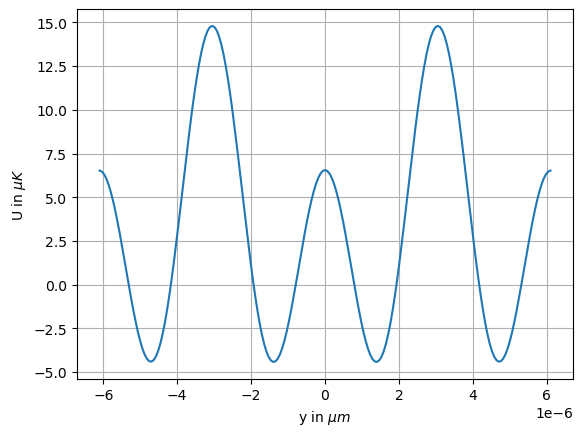

In [24]:
# # Approach: Symmetry double opt
# def modify_imbalance(phi_g,phi_r, fields_g=fields_g, fields_r=fields_r, val=a_s/2): # modifies field
#     fields_g[1].phase=phi_g
#     fields_r[1].phase=phi_r
#     dU_g=(intensity(fields_g, 0,val,0)-intensity(fields_g, 0,-val,0))*alpha_g
#     dUg=np.abs(U_l1)/kB*1E6; U_r=dUr/kB*1E6 # in 1E6 muK# in 1E6 muK
#     delta=abs(U_r-U_l)
#     return delta


def modify_imbalance(phase, fields, val=a_s/4): # modifies field
    fields[1].phase=phase
    delta=np.abs(intensity(fields, 0,val,0)-intensity(fields, 0,-val,0))/kB*1E6
    return delta

def center_doublewells(fields_g, fields_r, val_g=a_s/4, val_r=a_l/4):
    opt_g= lambda  x:modify_imbalance(x, fields=fields_g, val=a_s/4)
    opt_r= lambda  x:modify_imbalance(x, fields=fields_r, val=a_l/4)
    optimize.fmin(opt_g, x0=0)
    optimize.fmin(opt_r, x0=0)
    # print(min_pars)
    return "Done"

center_doublewells(fields_g, fields_r)

# plot single lattice site
Ny=5
Nx=5

# extract minima along y-axis in one line
y_opt=np.linspace(-a_l,a_l,201)
U_opt=np.zeros(len(y_opt))
x_opt,z_opt=0, 0
U_opttot=np.zeros(len(y_opt))
for i,y in enumerate(y_opt):
    U_optg=intensity(fields_g, x_opt,y,z_opt)*alpha_g; U_optr=intensity(fields_r, x_opt,y,z_opt)*alpha_r
    U_opttot[i]=(U_optg+U_optr)/kB*1E6
plt.plot(y_opt, U_opttot)
plt.grid()
plt.ylabel("U in $\mu K$")
plt.xlabel("y in $\mu m$")

# Plot lattices

  0%|          | 0/201 [00:00<?, ?it/s]

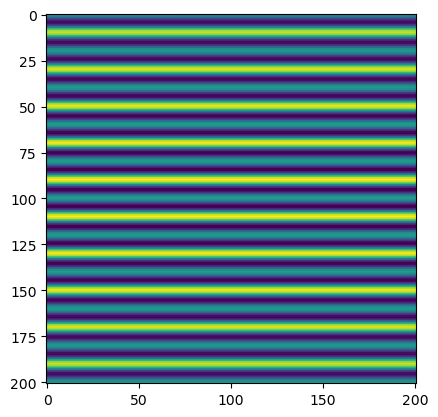

In [7]:
# plot single lattice site
Ny=5
Nx=5

x=np.linspace(-Nx*a_xy,Nx*a_xy,201)
y=np.linspace(-Ny*a_l,Ny*a_l,201)



U_gmap=np.zeros((len(y),len(x)))
U_rmap=np.zeros((len(y),len(x)))
for i,xs in tqdm(enumerate(x), total=len(x)): # progress bar
    for j,ys in enumerate(y):
        U_gmap[j,i]=intensity(fields_g, xs,ys,0)*alpha_g
        U_rmap[j,i]=intensity(fields_r, xs,ys,0)*alpha_r
U_allmap=U_gmap+U_rmap
plt.imshow(U_allmap)

## Function

In [8]:
class Udata:
    def __init__(self, x,y):
        self.x=x
        self.y=y
        
        # minima and wells
        self.locmin_i=[] # all indices
        self.mincen=np.zeros(2) # indices center
        self.wellsabove=[] # indices above
        self.wellsbelow=[] # indices below
        
        self.wellindex=[] # well-index with 0 at y=0
        self.wellarray=[] # array with all wells
        self.imbalances=[]
        pass
        
    def ex_loc_wells(self):
        if len(self.locmin_i)!=0: # reset if called twice
            self.locmin_i=[]
        
        for i in range(len(self.y)-1):
            if self.y[i-1]>=self.y[i] and self.y[i+1]>=self.y[i]:
                if len(self.locmin_i)!=0 and np.sign(self.x[self.locmin_i[-1]])!=np.sign(self.x[i]): # get center wells
                        self.mincen=[self.locmin_i[-1],i]
                self.locmin_i.append(i)
        self.locmin_i=np.array(self.locmin_i)
        
        # group doublwells
        if len(self.mincen)>=2:
            self.wellsabove=group2(self.locmin_i[self.locmin_i>self.mincen[1]])
            self.wellsbelow=group2(self.locmin_i[self.locmin_i<self.mincen[0]][::-1])
            
            self.wellindex=np.arange(-len(self.wellsbelow),len(self.wellsabove)+1)
            self.wellarray=self.wellsbelow+[self.mincen]+self.wellsabove
        pass
    
    def ex_imbalance(self):
        self.imbalances=np.zeros(len(self.wellarray))
        for i,well in enumerate(self.wellarray):
            self.imbalances[i]=self.y[well[1]]-self.y[well[0]] # sign delta: U(y(+x))-U(y(-x))
        pass

# Extract imbalances doublewells

## Translate phase to imbalance

In [ ]:
# phase_g0=-0.35644741
# # extract minima along y-axis in one line
# y_opt=np.linspace(-1*a_l/2,1*a_l/2,201)
# x_opt,z_opt=0, 0
# phi_max=25E-3 #mrad

# phase_space=np.linspace(-phi_max,phi_max,1001) # mrad
# imbalance_space=np.zeros(len(phase_space))


# U_transl=np.zeros(len(y_opt))
# for j, phase_rel in tqdm(enumerate(phase_space),total=len(phase_space)):
#     fields_g[1].phase=phase_g0+phase_rel*2
#     for i,y in enumerate(y_opt):
#         U_optg=intensity(fields_g, x_opt,y,z_opt)*alpha_g; U_optr=intensity(fields_r, x_opt,y,z_opt)*alpha_r
#         U_transl[i]=(U_optg+U_optr)/kB*1E6

#     Uopt_data=Udata(y_opt,U_transl)
#     Uopt_data.ex_loc_wells()
#     Uopt_data.ex_imbalance()
#     imbalance_space[j]=Uopt_data.imbalances
# fields_g[1].phase=phase_g0

In [ ]:
# # plt.plot(Uopt_data.x*1E6, Uopt_data.y)
# plt.plot(phase_space*1E3, imbalance_space)

# plt.grid()
# plt.ylabel("$\Delta$ in $\mu K$")
# plt.xlabel(r"$\varphi_{rel}$ in mrad")
# # reset to before:

# def linfit(x,a,b):
#     return a*x+b


# trans_phrad_imbmuK,_=optimize.curve_fit(linfit,phase_space, imbalance_space)
# fit_y=linfit(phase_space,trans_phrad_imbmuK[0],trans_phrad_imbmuK[1])
# plt.plot(phase_space*1E3,fit_y,linestyle="--")

# def imb_to_phase(y,a=trans_phrad_imbmuK[0],b=trans_phrad_imbmuK[1]): # imbalance to relative phase
#     return (y-b)/a 

### Single line

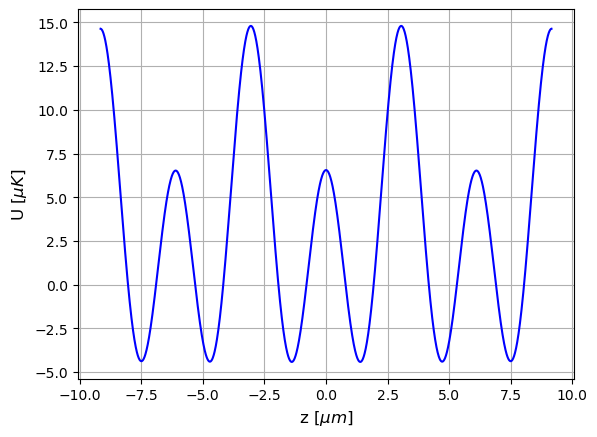

In [34]:
# extract minima along y-axis in one line
N=1.5
y_opt=np.linspace(-N*a_l,N*a_l,2001)
U_opt=np.zeros(len(y_opt))
x_opt,z_opt=0, 0
# U_optg, U_optr =np.zeros(len(y_opt)),np.zeros(len(y_opt))
U_opttot=np.zeros(len(y_opt))
for i,y in enumerate(y_opt):
    U_optg=intensity(fields_g, x_opt,y,z_opt)*alpha_g; U_optr=intensity(fields_r, x_opt,y,z_opt)*alpha_r
    U_opttot[i]=(U_optg+U_optr)/kB*1E6

Uopt_data=Udata(y_opt,U_opttot)
Uopt_data.ex_loc_wells()
plt.plot(Uopt_data.x*1E6, Uopt_data.y, color="blue")
# plt.scatter(Uopt_data.x[Uopt_data.locmin_i]*1E6, Uopt_data.y[Uopt_data.locmin_i])
# plt.scatter(Uopt_data.x[Uopt_data.mincen]*1E6, Uopt_data.y[Uopt_data.mincen], color="red") # mark central wells

plt.grid()
plt.ylabel("U [$\mu K$]",fontsize=12)
plt.xlabel("y [$\mu m$]", fontsize=12)
plt.xlabel("z [$\mu m$]", fontsize=12) # thesis

# # Imbalances:
# Uopt_data.ex_imbalance()
# print("Imabalances in  muK", Uopt_data.imbalances)
plt.savefig("lattice-depth-absolute.pdf",bbox_inches="tight")

### Compare with ideal

In [31]:
# ideal fields (no astigmatism)
P=2
E0_gl=E0_gen(P,w_gl_inpl,w_gl_outpl);  E0_gs=E0_gen(P,w_gs_inpl,w_gs_outpl)
E0_rl=E0_gen(P,w_rl_inpl,w_rl_outpl);  E0_rs=E0_gen(P,w_rs_inpl,w_rs_outpl)
# polvec2=np.cross(k_r,[0,0,1])


# green
field_gl_ideal=field_2D(wavelen_g,w_gs_inpl,w_gs_outpl,k_l,polvec, 0, 0, E0_gs, phase=0)
field_gr_ideal=field_2D(wavelen_g,w_gl_inpl,w_gl_outpl,k_r,polvec, 0, 0, E0_gl, phase=0)
# red
field_rl_ideal=field_2D(wavelen_r,w_rs_inpl,w_rs_outpl,k_l,polvec, 0, 0, E0_rs, phase=0)
field_rr_ideal=field_2D(wavelen_r,w_rl_inpl,w_rl_outpl,k_r,polvec, 0, 0, E0_rl, phase=0)

fields_g_ideal=[field_gr_ideal,field_gl_ideal]
fields_r_ideal=[field_rr_ideal,field_rl_ideal]

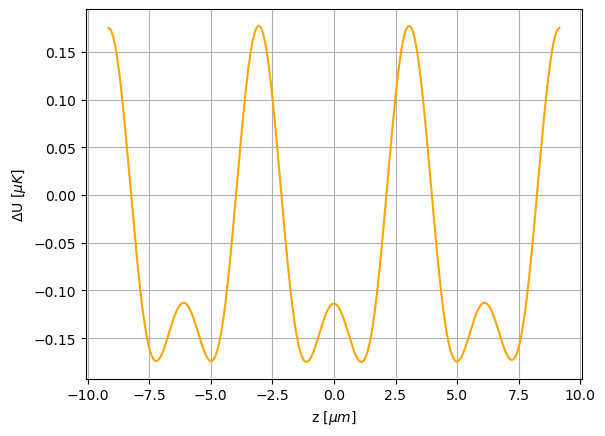

In [33]:


# extract minima along y-axis in one line
N=1.5
y_opt=np.linspace(-N*a_l,N*a_l,2001)
U_opt=np.zeros(len(y_opt))
x_opt,z_opt=0, 0
# U_optg, U_optr =np.zeros(len(y_opt)),np.zeros(len(y_opt))
U_opttot=np.zeros(len(y_opt))
U_opttot_ideal=np.zeros(len(y_opt))
for i,y in enumerate(y_opt):
    # what we have
    U_optg=intensity(fields_g, x_opt,y,z_opt)*alpha_g; U_optr=intensity(fields_r, x_opt,y,z_opt)*alpha_r
    U_opttot[i]=(U_optg+U_optr)/kB*1E6
    # ideal
    U_optg_ideal=intensity(fields_g_ideal, x_opt,y,z_opt)*alpha_g; U_optr_ideal=intensity(fields_r_ideal, x_opt,y,z_opt)*alpha_r
    U_opttot_ideal[i]=(U_optg_ideal+U_optr_ideal)/kB*1E6

Uopt_data=Udata(y_opt,U_opttot)
Uopt_data_ideal=Udata(y_opt,U_opttot_ideal)
# plt.plot(Uopt_data.x*1E6, Uopt_data.y)
# plt.plot(Uopt_data_ideal.x*1E6, Uopt_data_ideal.y)
plt.plot(Uopt_data_ideal.x*1E6, Uopt_data_ideal.y-Uopt_data.y, color="orange")
# plt.plot(Uopt_data.x[ratio<=1]*1E6, ratio[ratio<=1])
# plt.scatter(Uopt_data.x[Uopt_data.locmin_i]*1E6, Uopt_data.y[Uopt_data.locmin_i])
# plt.scatter(Uopt_data.x[Uopt_data.mincen]*1E6, Uopt_data.y[Uopt_data.mincen], color="red") # mark central wells

plt.grid()
plt.ylabel("$\Delta$U [$\mu K$]")
plt.xlabel("z [$\mu m$]")
plt.savefig("lattice-depth-difference.pdf",bbox_inches="tight")

### 2D along xy-lattices

In [ ]:
Nx=15
Nz=15
n_dim=2
res_y=1301

x_array=np.arange(-Nx,Nx+1)*a_xy
z_array=np.arange(-Nz,Nz+1)*a_xy
y_array=np.linspace(-n_dim,n_dim, res_y)*a_l

linearray=np.zeros((len(z_array),len(x_array)),dtype="object")
imbalance_array=np.zeros((len(z_array),len(x_array),2*n_dim-1))

Us=np.zeros(len(y_array)) # temp array
for i,z in tqdm(enumerate(z_array), total=len(z_array)): # progress bar
    for j,x in enumerate(x_array):
        Us=np.zeros(len(y_array)) # temp array
        for count, y in enumerate(y_array):
            U_g=intensity(fields_g, x,y,z)*alpha_g
            U_r=intensity(fields_r, x,y,z)*alpha_r
            Us[count]=(U_g+U_r)/kB*1E6 # in muK
        linearray[i,j]=Udata(y_array,Us)
        # extract wells
        linearray[i,j].ex_loc_wells()
        linearray[i,j].ex_imbalance()
        imbalance_array[i,j,:]=linearray[i,j].imbalances


print("Done")

# plt.imshow(imbalance_array[:,:,0], interpolation=None, origin="lower")
# plt.colorbar()

## imbalance in muK

In [ ]:
order=-1
imdata=imbalance_array[:,:,list(linearray[0,0].wellindex).index(order)]

fig, ax = plt.subplots()

im= ax.imshow(imdata*1E3, interpolation=None, origin="lower")
fig.colorbar(im,ax=ax, label="doublewell imbalance in $nK$")

ax.set_xticks(get_evenly_spaced(np.arange(len(x_array)),5),get_evenly_spaced(x_array/a_xy,5).astype(int))
ax.set_yticks(get_evenly_spaced(np.arange(len(z_array)),5),get_evenly_spaced(z_array/a_xy,5).astype(int))
plt.xlabel("# long lattice-site along x", fontsize=15)
plt.ylabel("# long lattice-site along y", fontsize=15)
plt.title("order:{}".format(order), fontsize=15)


## Imbalance in mrad

In [ ]:
order=0


imdata=imbalance_array[:,:,list(linearray[0,0].wellindex).index(order)]
imdata=imb_to_phase(imdata)*1E3 # in mrad

fig, ax = plt.subplots()

im= ax.imshow(imdata, interpolation=None, origin="lower")
fig.colorbar(im,ax=ax, label="doublewell imbalance in $mrad$")

ax.set_xticks(get_evenly_spaced(np.arange(len(x_array)),5),get_evenly_spaced(x_array/a_xy,5).astype(int))
ax.set_yticks(get_evenly_spaced(np.arange(len(z_array)),5),get_evenly_spaced(z_array/a_xy,5).astype(int))
plt.xlabel("# long lattice-site along x")
plt.ylabel("# long lattice-site along y")
plt.title("order:{}".format(order))

# Optimize for balance along y-axis

In [ ]:
# plot single lattice
N=1

x=np.linspace(-10*a_xy,10*a_xy,201)
y=np.linspace(-N*a_l,N*a_l,201)



U_gmap=np.zeros((len(y),len(x)))
U_rmap=np.zeros((len(y),len(x)))
for i,xs in tqdm(enumerate(x), total=len(x)): # progress bar
    for j,ys in enumerate(y):
        U_gmap[j,i]=intensity(fields_g, xs,ys,0)*alpha_g
        U_rmap[j,i]=intensity(fields_r, xs,ys,0)*alpha_r
U_allmap=U_gmap+U_rmap
plt.imshow(U_allmap)

In [ ]:
# extract minima along y-axis in one line
N=2
y_opt=np.linspace(-N*a_l,N*a_l,201)
U_opt=np.zeros(len(y_optim))
x_opt,z_opt=0, 0
# U_optg, U_optr =np.zeros(len(y_opt)),np.zeros(len(y_opt))
U_opttot=np.zeros(len(y_opt))
for i,y in enumerate(y_opt):
    U_optg=intensity(fields_g, x_opt,y,z_opt)*alpha_g; U_optr=intensity(fields_r, x_opt,y,z_opt)*alpha_r
    U_opttot[i]=(U_optg+U_optr)/kB*1E6

Uopt_data=Udata(y_opt,U_opttot)
Uopt_data.ex_loc_wells()
plt.plot(Uopt_data.x, Uopt_data.y)
plt.scatter(Uopt_data.x[Uopt_data.locmin_i], Uopt_data.y[Uopt_data.locmin_i])
plt.scatter(Uopt_data.x[Uopt_data.mincen], Uopt_data.y[Uopt_data.mincen], color="red") # mark central wells

plt.grid()
plt.ylabel("U in $\mu K$")
plt.xlabel("y in $\mu m$")

In [ ]:
# # Well finding: check single well:
# i=1
# j=6
# Uopt_data=linearray[i,j]

# plt.plot(Uopt_data.x*1E6, Uopt_data.y)
# plt.scatter(Uopt_data.x[Uopt_data.locmin_i]*1E6, Uopt_data.y[Uopt_data.locmin_i])
# plt.scatter(Uopt_data.x[Uopt_data.mincen]*1E6, Uopt_data.y[Uopt_data.mincen], color="red") # mark central wells

# plt.grid()
# plt.ylabel("U in $\mu K$")
# plt.xlabel("y in $\mu m$")

# # Imbalances:
# Uopt_data.ex_imbalance()
# print("Imabalances in  muK", Uopt_data.imbalances)
# plt.ylim([min(Uopt_data.y[Uopt_data.locmin_i]),min(Uopt_data.y[Uopt_data.locmin_i])+0.3])